# Fuel Energy Principal Component Analysis (PCA) and Hierarchical Clustering

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from sklearn.metrics import (r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error)
from sklearn.preprocessing import PowerTransformer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from IPython.display import display

# Import fuel_energy dataframe
fuel_energy=pd.read_csv('fuel_energy.csv')

In [2]:
fuel_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4703 entries, 0 to 4702
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                4703 non-null   object 
 1   account_id                  4703 non-null   int64  
 2   Year                        4703 non-null   int64  
 3   incorporated_country        4703 non-null   object 
 4   Primary activity            4703 non-null   object 
 5   Primary sector              4703 non-null   object 
 6   Market_Cap_USD              4038 non-null   float64
 7   Third_party_verification    4700 non-null   object 
 8   Revenue_USD                 4060 non-null   float64
 9   ebitda_USD                  4060 non-null   float64
 10  grossProfit_USD             4060 non-null   float64
 11  netIncome_USD               4060 non-null   float64
 12  cashAndCashEquivalents_USD  4060 non-null   float64
 13  shortTermInvestments_USD    4060 

In [3]:
fuel_energy.head()

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9.548124e+09,Third-party verification or assurance process ...,1.728470e+09,1.565910e+09,...,8.544560e+09,1.107567e+10,1.031240e+09,8.544560e+09,7.302500e+08,1.004443e+10,Fuel-and-energy-related activities (not includ...,61.42,3.389500e+02,4072324
1,abrdn,17604,2018,United Kingdom,Insurance,Financial services,1.019344e+10,Third-party verification or assurance process ...,2.912110e+09,1.482090e+09,...,6.626860e+09,1.589659e+10,6.322060e+09,6.626860e+09,1.647190e+09,9.574530e+09,Fuel-and-energy-related activities (not includ...,1373.00,7.197250e+03,4072324
2,Aptiv,4407,2018,United Kingdom,Electrical equipment,Electrical & electronic equipment,1.595156e+10,No third-party verification or assurance,1.443500e+10,2.260000e+09,...,9.900000e+07,1.248000e+10,8.810000e+09,1.710000e+08,4.344000e+09,3.670000e+09,Fuel-and-energy-related activities (not includ...,103000.00,3.804718e+05,4072324
3,Arm Ltd.,950,2018,United Kingdom,Electronic components,Electrical & electronic equipment,NaN,No third-party verification or assurance,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Fuel-and-energy-related activities (not includ...,2078.37,7.728538e+03,4072324
4,Associated British Foods,1085,2018,United Kingdom,Apparel stores,Discretionary retail,2.051429e+10,Third-party verification or assurance process ...,1.977898e+10,2.363470e+09,...,3.429000e+08,1.738884e+10,5.582920e+09,3.810000e+08,9.880600e+08,1.180592e+10,Fuel-and-energy-related activities (not includ...,452806.00,2.801746e+06,4072324


In [4]:
# Rename features
fuel_energy = fuel_energy.rename(columns={'incorporated_country': 'Countries',
                                          'Primary activity': 'Primary_activity',
                                          'Primary sector': 'Primary_sector'})

# Drop unneeded columns
fuel_energy = fuel_energy.drop(
    ['Third_party_verification', 'Scope_3_emissions_type'], axis=1, errors='ignore')

fuel_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4703 entries, 0 to 4702
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                4703 non-null   object 
 1   account_id                  4703 non-null   int64  
 2   Year                        4703 non-null   int64  
 3   Countries                   4703 non-null   object 
 4   Primary_activity            4703 non-null   object 
 5   Primary_sector              4703 non-null   object 
 6   Market_Cap_USD              4038 non-null   float64
 7   Revenue_USD                 4060 non-null   float64
 8   ebitda_USD                  4060 non-null   float64
 9   grossProfit_USD             4060 non-null   float64
 10  netIncome_USD               4060 non-null   float64
 11  cashAndCashEquivalents_USD  4060 non-null   float64
 12  shortTermInvestments_USD    4060 non-null   float64
 13  longTermInvestments_USD     4060 

In [5]:
# Looking at missing data
print(fuel_energy.isnull().mean().sort_values(ascending=False).round(3) * 100)

Market_Cap_USD                14.1
cashAndCashEquivalents_USD    13.7
totalLiabilities_USD          13.7
totalEquity_USD               13.7
totalDebt_USD                 13.7
Revenue_USD                   13.7
ebitda_USD                    13.7
grossProfit_USD               13.7
netIncome_USD                 13.7
totalInvestments_USD          13.7
shortTermInvestments_USD      13.7
longTermInvestments_USD       13.7
totalAssets_USD               13.7
scope_1_2_emissions_amount     0.2
Scope_3_emissions_amount       0.0
account_name                   0.0
account_id                     0.0
Primary_sector                 0.0
Primary_activity               0.0
Countries                      0.0
Year                           0.0
Year_sq                        0.0
dtype: float64


### Principal Component Analysis (PCA) Feature Engineering — Fuel & Energy Dataset

1. **Select Numeric Features**
   - Exclude identifier and categorical columns from the `fuel_energy` dataset.
   - Select all remaining numeric columns (except the target, `Scope_3_emissions_amount`) for PCA.

2. **Sign-Log Transformation**
   - Apply a signed log transformation to each numeric feature to handle skewed distributions and negative/zero values.

3. **Handle Missing Values**
   - Drop rows with missing values in any selected numeric feature.
   - Track the indices of rows used for PCA to enable proper alignment later.

4. **Standardize Data**
   - Standardize the transformed features to zero mean and unit variance before PCA.

5. **Fit PCA**
   - Fit PCA to the standardized data and extract all principal components.

6. **Create and Merge Principal Component Features**
   - Store principal component scores in a DataFrame with indices matching the original data.
   - Append PC columns back to the original `fuel_energy` DataFrame, filling only the valid rows.

7. **Plot Explained Variance**
   - Plot a scree plot and a cumulative explained variance plot to assess the number of principal components to retain.

8. **Print Cumulative Variance**
   - Print the cumulative variance explained by each principal component for interpretability and reporting.

---

**Result:**  
The DataFrame `fuel_energy_with_pcs` contains the original data plus principal component features for rows where PCA was applicable. This enables dimensionality-reduced, normalized feature engineering for downstream modeling or analysis.

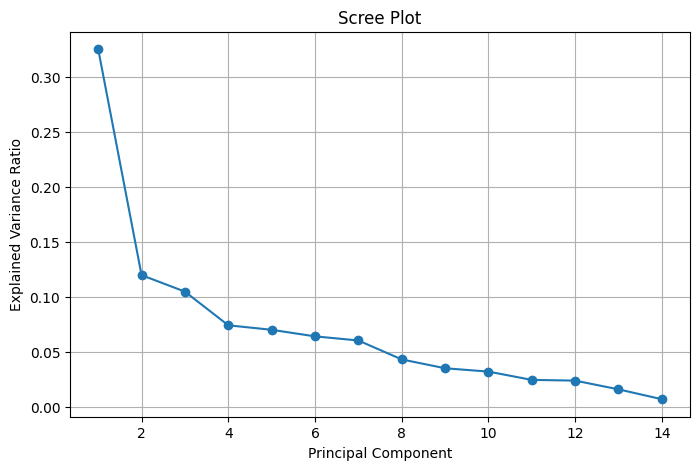

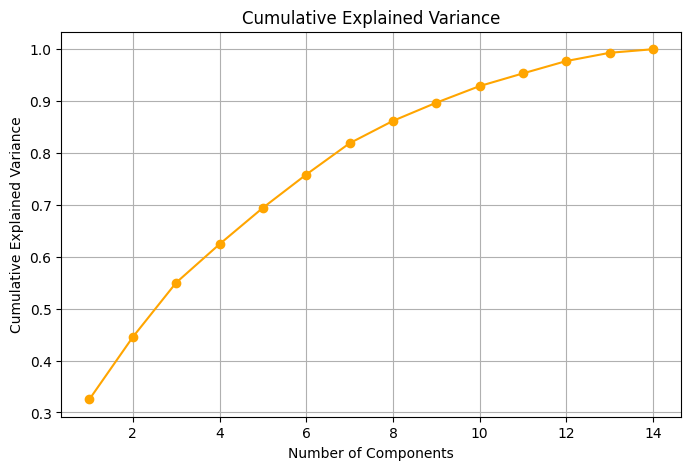

Cumulative variance explained by each additional principal component:
  PC1: 0.3255
  PC2: 0.4453
  PC3: 0.5501
  PC4: 0.6243
  PC5: 0.6944
  PC6: 0.7585
  PC7: 0.8188
  PC8: 0.8619
  PC9: 0.8970
  PC10: 0.9290
  PC11: 0.9535
  PC12: 0.9773
  PC13: 0.9931
  PC14: 1.0000


In [6]:
# --- STEP 1: Select appropriate columns for PCA ---
exclude_cols = [
    "account_id", "Year", "Year_sq",
    "account_name", "Countries", "Primary_activity", "Primary_sector"
]
numeric_cols = [
    col for col in fuel_energy.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(fuel_energy[col])
    and col != "Scope_3_emissions_amount"
]
X = fuel_energy[numeric_cols].copy()

# --- STEP 2: Apply sign-log transformation ---
def sign_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
X_transformed = X.apply(sign_log_transform)

# --- STEP 3: Drop rows with missing values (keep track of indices) ---
X_dropped = X_transformed.dropna()
pca_indices = X_dropped.index

# --- STEP 4: Standardize the data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dropped)

# --- STEP 5: Fit PCA ---
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# --- STEP 6: Create a DataFrame for PCs, index matches original ---
num_pcs = X_pca.shape[1]
pc_columns = [f"PC{i+1}" for i in range(num_pcs)]
pcs_df = pd.DataFrame(X_pca, columns=pc_columns, index=pca_indices)

# --- STEP 7: Append PCs back to the original DataFrame (only for valid rows) ---
fuel_energy_with_pcs = fuel_energy.copy()
for col in pc_columns:
    fuel_energy_with_pcs[col] = np.nan  # initialize with NaN

fuel_energy_with_pcs.loc[pcs_df.index, pc_columns] = pcs_df

# --- Plots ---
explained_var_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(explained_var_ratio) + 1),
    np.cumsum(explained_var_ratio),
    marker='o',
    color='orange'
)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# --- Print cumulative variance explained for each PC ---
cumulative_var = np.cumsum(explained_var_ratio)
print("Cumulative variance explained by each additional principal component:")
for i, var in enumerate(cumulative_var, start=1):
    print(f"  PC{i}: {var:.4f}")

# --- END ---
# fuel_energy_with_pcs now contains the principal components for valid rows.

Seven pc's explains **>80%** of the variance in the data, while 4 pc's is at the bottom of the "elbow" with much less significant return for each increase in number of pc's.<br>
I'll investigate both 7 pc's and 4 pc's performance on HLM models.

Ten pc's were evaluated and multicolinearity existed, so explained variance was decreased to >80% rather than >90% benchmark.

### Hierarchical Linear Modeling (HLM) with PC7 Features — Fuel & Energy Dataset

1. **PCA Feature Engineering**
    - Select numeric features, excluding identifiers/categoricals.
    - Apply a signed-log transform to handle skewed/negative data.
    - Drop rows with missing values before PCA.
    - Fit PCA for 7 components (`PC7_1`–`PC7_7`) and 4 components (`PC4_1`–`PC4_4`); merge into the main DataFrame.

2. **Target Engineering**
    - Add a signed-log transformed target column (`slog_Scope_3_emissions_amount`).

3. **Splitting for HLM**
    - Use only rows included in the PCA.
    - Split into training (2018–2022) and test (2023) sets, retaining only companies present in both periods.

4. **Feature/Target Filtering**
    - Retain rows with no missing values for PC7 features, the target, and categorical/contextual variables.

5. **Category Consistency Checks**
    - Ensure the test set contains only categorical levels present in training.
    - Drop and warn on any unseen categories.

6. **Modeling**
    - Fit a MixedLM using PC7 features, categorical/contextual variables as fixed effects, and `account_id` as the grouping variable for random effects.
    - Output model summary and R² metrics.

7. **Evaluation**
    - Predict on the test set (log and original scale).
    - Compute R², MAPE, MAE, RMSE, RMSLE on both scales.
    - Print metrics summary.

8. **Feature Importance**
    - Output top features by p-value and all coefficients sorted by absolute value.

9. **Visualization**
    - Plot densities and histograms (log and original scale) for reported versus predicted values.

10. **Export Metrics**
    - Store model metrics and observation counts in a dictionary for downstream analysis.

---

**Result:**  
This script performs PCA, merges features, and splits the data into train (2018–2022) and test (2023, only previously-seen companies.

In [10]:
# --- Prepare Data ---
exclude_cols = [
    "account_id", "Year", "Year_sq",
    "account_name", "Countries", "Primary_activity", "Primary_sector"
]
numeric_cols = [
    col for col in fuel_energy.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(fuel_energy[col])
    and col != "Scope_3_emissions_amount"
]
X = fuel_energy[numeric_cols].copy()

def sign_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
X_transformed = X.apply(sign_log_transform)
pca_data = X_transformed.dropna().copy()
pca_data["account_id"] = fuel_energy.loc[pca_data.index, "account_id"]
pca_data["Year"] = fuel_energy.loc[pca_data.index, "Year"]

X_pca_input = pca_data.drop(columns=["account_id", "Year"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca_input)

# --- PCA for 7 components ---
pca7 = PCA(n_components=7)
pcs7 = pca7.fit_transform(X_scaled)
pcs7_df = pd.DataFrame(pcs7, columns=[f"PC7_{i+1}" for i in range(7)], index=pca_data.index)

# --- PCA for 4 components ---
pca4 = PCA(n_components=4)
pcs4 = pca4.fit_transform(X_scaled)
pcs4_df = pd.DataFrame(pcs4, columns=[f"PC4_{i+1}" for i in range(4)], index=pca_data.index)

# --- Merge all PC features to original DataFrame ---
fuel_energy_pca = fuel_energy.copy()
fuel_energy_pca = fuel_energy_pca.join(pcs7_df)
fuel_energy_pca = fuel_energy_pca.join(pcs4_df)

# --- Add transformed target and optionally other features ---
fuel_energy_pca['slog_Scope_3_emissions_amount'] = sign_log_transform(fuel_energy_pca['Scope_3_emissions_amount'])

# Optional: Rename columns for consistency
fuel_energy_pca = fuel_energy_pca.rename(columns={'incorporated_country': 'Countries',
                                                 'Primary activity': 'Primary_activity',
                                                 'Primary sector': 'Primary_sector'})

# Now fuel_energy_pca contains all PC7 and PC4 features for downstream HLM modeling

# --- Data Splitting Step (for all models, all features: original, PC4, PC7, etc.) ---
fuel_energy_modeling = fuel_energy_pca  # Use your enriched DataFrame

# Train: 2018-2022, Test: 2023, test only companies seen in training
train_df_modeling = fuel_energy_modeling[
    (fuel_energy_modeling['Year'] >= 2018) & (fuel_energy_modeling['Year'] <= 2022)
].copy()
test_df_modeling = fuel_energy_modeling[
    (fuel_energy_modeling['Year'] == 2023)
].copy()
valid_companies = set(train_df_modeling['account_id'].unique())
test_df_modeling = test_df_modeling[test_df_modeling['account_id'].isin(valid_companies)].copy()

# Now train_df_modeling and test_df_modeling are ready for use in any downstream model (original/log/PC4/PC7/etc).

In [11]:
fuel_energy_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4703 entries, 0 to 4702
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   4703 non-null   object 
 1   account_id                     4703 non-null   int64  
 2   Year                           4703 non-null   int64  
 3   Countries                      4703 non-null   object 
 4   Primary_activity               4703 non-null   object 
 5   Primary_sector                 4703 non-null   object 
 6   Market_Cap_USD                 4038 non-null   float64
 7   Revenue_USD                    4060 non-null   float64
 8   ebitda_USD                     4060 non-null   float64
 9   grossProfit_USD                4060 non-null   float64
 10  netIncome_USD                  4060 non-null   float64
 11  cashAndCashEquivalents_USD     4060 non-null   float64
 12  shortTermInvestments_USD       4060 non-null   f

In [12]:
train_df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3797 entries, 0 to 3796
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   3797 non-null   object 
 1   account_id                     3797 non-null   int64  
 2   Year                           3797 non-null   int64  
 3   Countries                      3797 non-null   object 
 4   Primary_activity               3797 non-null   object 
 5   Primary_sector                 3797 non-null   object 
 6   Market_Cap_USD                 3253 non-null   float64
 7   Revenue_USD                    3306 non-null   float64
 8   ebitda_USD                     3306 non-null   float64
 9   grossProfit_USD                3306 non-null   float64
 10  netIncome_USD                  3306 non-null   float64
 11  cashAndCashEquivalents_USD     3306 non-null   float64
 12  shortTermInvestments_USD       3306 non-null   float6

In [14]:
test_df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 868 entries, 3797 to 4702
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   868 non-null    object 
 1   account_id                     868 non-null    int64  
 2   Year                           868 non-null    int64  
 3   Countries                      868 non-null    object 
 4   Primary_activity               868 non-null    object 
 5   Primary_sector                 868 non-null    object 
 6   Market_Cap_USD                 752 non-null    float64
 7   Revenue_USD                    722 non-null    float64
 8   ebitda_USD                     722 non-null    float64
 9   grossProfit_USD                722 non-null    float64
 10  netIncome_USD                  722 non-null    float64
 11  cashAndCashEquivalents_USD     722 non-null    float64
 12  shortTermInvestments_USD       722 non-null    floa

### HLM with 7 Principal Components (PC7) — Fuel & Energy Dataset

1. **Feature Engineering**
    - Numeric columns are signed-log transformed and used for PCA (PC7 and PC4 merged into the main DataFrame).
2. **Target Preparation**
    - Add a signed-log transformed target.
3. **Train/Test Split**
    - Train: 2018–2022, Test: 2023; only companies present in both sets are used.
4. **Modeling**
    - Filter for complete cases (PC7, target, categoricals).
    - Ensure test categories match training.
    - Fit a hierarchical mixed-effects model with PC7, year, country, and activity as fixed effects, and company as a random effect.
5. **Evaluation & Output**
    - Predict on test set, compute standard regression metrics, display model summary, top features, and plots.

---

**Result:**  
This pipeline enables PCA-based HLM modeling and evaluation on consistent, robust fuel & energy data splits.

                                         Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               slog_Scope_3_emissions_amount
No. Observations:                 3242                  Method:                           ML                           
No. Groups:                       771                   Scale:                            0.9381                       
Min. group size:                  1                     Log-Likelihood:                   -5143.4799                   
Max. group size:                  5                     Converged:                        Yes                          
Mean group size:                  4.2                                                                                  
-----------------------------------------------------------------------------------------------------------------------
                                                                           Coef. 

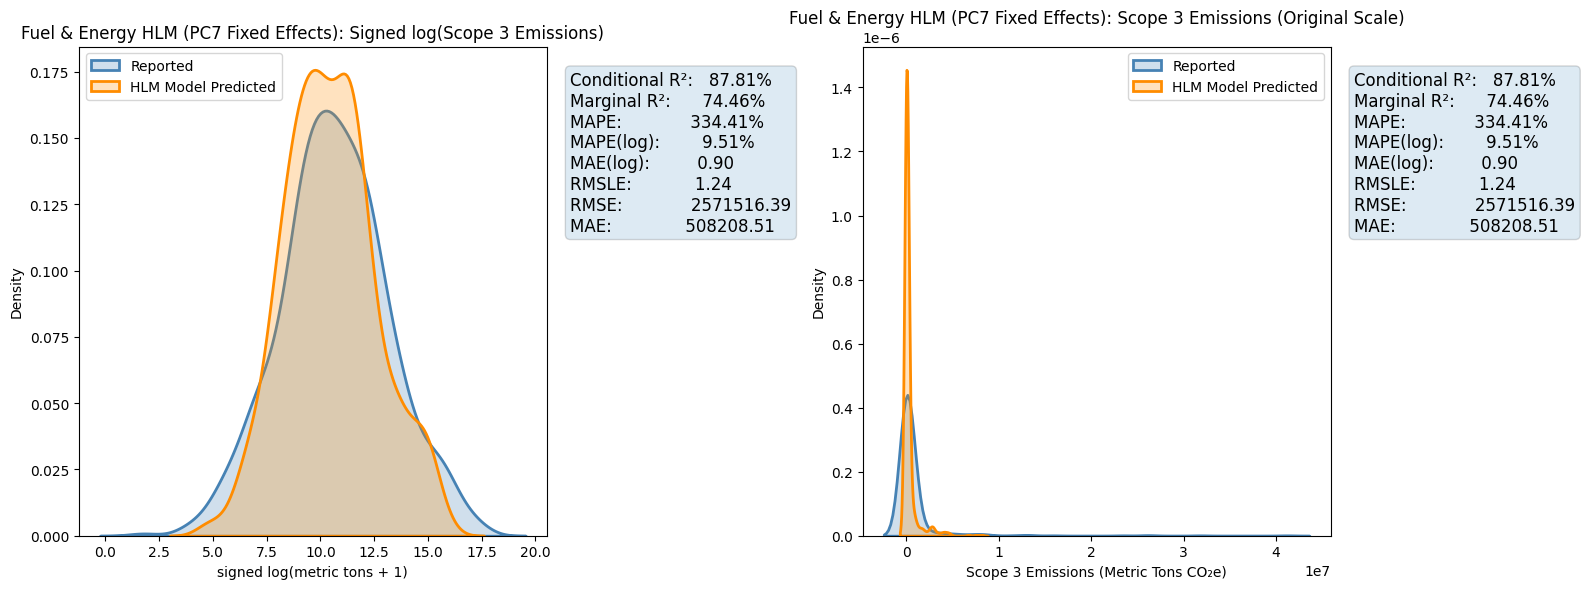

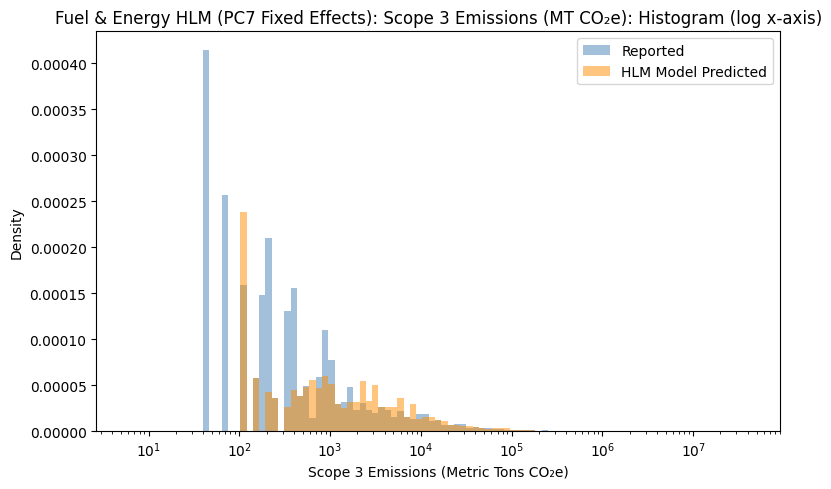

In [15]:
# --- Use previously created train_df_modeling and test_df_modeling ---

# --- 1. Filter for required columns only ---
feature_cols_PC7 = [f'PC7_{i}' for i in range(1, 8)]  # includes PC7_1 to PC7_7
target_col_PC7 = 'slog_Scope_3_emissions_amount'
cat_cols_PC7 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_PC7 = feature_cols_PC7 + [target_col_PC7] + cat_cols_PC7
train_df_PC7 = train_df_modeling.dropna(subset=all_model_vars_PC7).copy()
test_df_PC7 = test_df_modeling.dropna(subset=all_model_vars_PC7).copy()

# --- 2. Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_PC7[cat_col].unique())
    n_before = len(test_df_PC7)
    test_df_PC7 = test_df_PC7[test_df_PC7[cat_col].isin(train_cats)]
    n_after = len(test_df_PC7)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_PC7.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- 3. Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_PC7) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_PC7} ~ {fixed_effects}'

    # --- 4. Fit the mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_PC7, groups=train_df_PC7['account_id'])
        mdf_PC7 = md.fit(reml=False)
    print(mdf_PC7.summary())

    # --- 5. CALCULATE CONDITIONAL AND MARGINAL R² ---
    var_fixed = np.var(mdf_PC7.fittedvalues)
    var_resid = mdf_PC7.scale
    var_random = mdf_PC7.cov_re.iloc[0, 0] if mdf_PC7.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- 6. Predict on test set ---
    test_df_PC7['predicted_log'] = mdf_PC7.predict(test_df_PC7)
    test_df_PC7['predicted'] = np.sign(test_df_PC7['predicted_log']) * (np.expm1(np.abs(test_df_PC7['predicted_log'])))

    # --- 7. Metrics ---
    y_true_log = test_df_PC7[target_col_PC7]
    y_pred_log = test_df_PC7['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_PC7['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nFuel & Energy HLM with PC7 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- 8. Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_PC7.params,
        'pvalue': mdf_PC7.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- 9. Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Fuel & Energy HLM (PC7 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Fuel & Energy HLM (PC7 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Fuel & Energy HLM (PC7 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 10. RETURN METRICS FOR SUMMARY TABLE ---
    PC7_model_metrics = {
        "Model": "HLM PC7",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_PC7),
        "# Obs (test)": len(test_df_PC7),
        "# Obs (train/test)": f"{len(train_df_PC7)}/{len(test_df_PC7)}"
    }

In [17]:
train_df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3797 entries, 0 to 3796
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   3797 non-null   object 
 1   account_id                     3797 non-null   int64  
 2   Year                           3797 non-null   int64  
 3   Countries                      3797 non-null   object 
 4   Primary_activity               3797 non-null   object 
 5   Primary_sector                 3797 non-null   object 
 6   Market_Cap_USD                 3253 non-null   float64
 7   Revenue_USD                    3306 non-null   float64
 8   ebitda_USD                     3306 non-null   float64
 9   grossProfit_USD                3306 non-null   float64
 10  netIncome_USD                  3306 non-null   float64
 11  cashAndCashEquivalents_USD     3306 non-null   float64
 12  shortTermInvestments_USD       3306 non-null   float6

### HLM with 4 Principal Components (PC4) — Fuel & Energy Dataset

1. **Split & Filter**
    - Use universal train and test splits containing all features.
    - Select PC4 features, signed-log target, and categoricals; drop incomplete rows.
2. **Category Consistency**
    - Restrict test set to categories seen in training.
3. **Modeling**
    - Fit a mixed-effects (HLM) model: PC4, year, country, and activity as fixed effects; company as a random effect.
4. **Evaluation & Output**
    - Predict on the test set, compute regression metrics, print model summary and feature importance, visualize prediction vs. truth.

---

**Result:**  
This pipeline enables hierarchical modeling and evaluation using 4 principal components for fuel & energy emission prediction, leveraging robust and consistent data splits.

                                         Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               slog_Scope_3_emissions_amount
No. Observations:                 3242                  Method:                           ML                           
No. Groups:                       771                   Scale:                            0.9317                       
Min. group size:                  1                     Log-Likelihood:                   -5209.8807                   
Max. group size:                  5                     Converged:                        Yes                          
Mean group size:                  4.2                                                                                  
-----------------------------------------------------------------------------------------------------------------------
                                                                           Coef. 

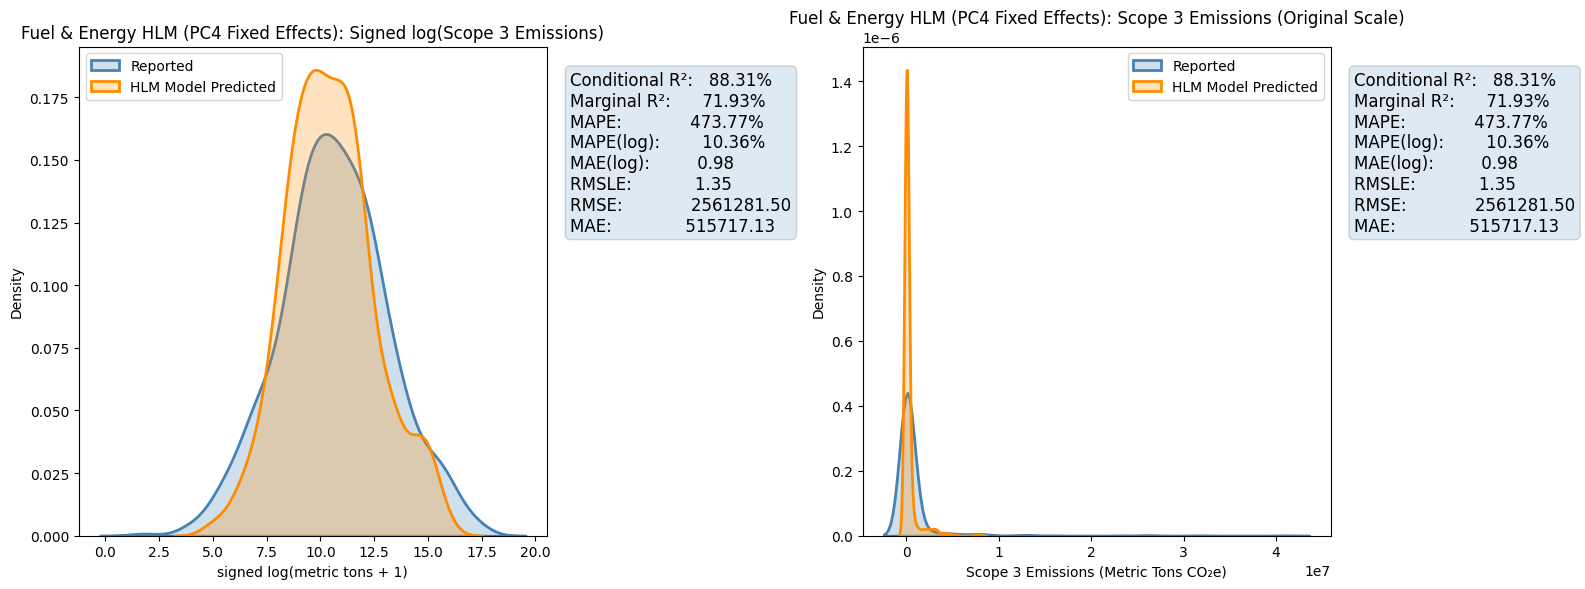

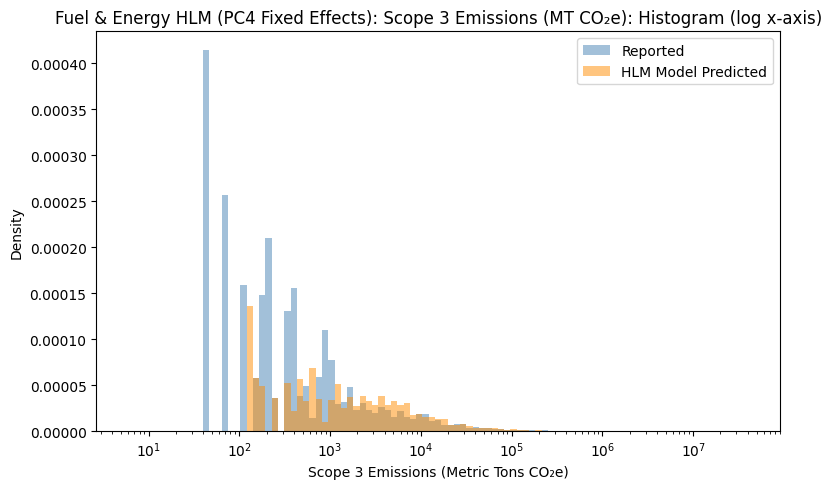

In [18]:
# --- Use previously created train_df_modeling and test_df_modeling ---

# --- 1. Filter for required columns only ---
feature_cols_PC4 = [f'PC4_{i}' for i in range(1, 5)]  # PC4_1 to PC4_4
target_col_PC4 = 'slog_Scope_3_emissions_amount'
cat_cols_PC4 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_PC4 = feature_cols_PC4 + [target_col_PC4] + cat_cols_PC4
train_df_PC4 = train_df_modeling.dropna(subset=all_model_vars_PC4).copy()
test_df_PC4 = test_df_modeling.dropna(subset=all_model_vars_PC4).copy()

# --- 2. Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_PC4[cat_col].unique())
    n_before = len(test_df_PC4)
    test_df_PC4 = test_df_PC4[test_df_PC4[cat_col].isin(train_cats)]
    n_after = len(test_df_PC4)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_PC4.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- 3. Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_PC4) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_PC4} ~ {fixed_effects}'

    # --- 4. Fit the mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_PC4, groups=train_df_PC4['account_id'])
        mdf_PC4 = md.fit(reml=False)
    print(mdf_PC4.summary())

    # --- 5. CALCULATE CONDITIONAL AND MARGINAL R² ---
    var_fixed = np.var(mdf_PC4.fittedvalues)
    var_resid = mdf_PC4.scale
    var_random = mdf_PC4.cov_re.iloc[0, 0] if mdf_PC4.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- 6. Predict on test set ---
    test_df_PC4['predicted_log'] = mdf_PC4.predict(test_df_PC4)
    test_df_PC4['predicted'] = np.sign(test_df_PC4['predicted_log']) * (np.expm1(np.abs(test_df_PC4['predicted_log'])))

    # --- 7. Metrics ---
    y_true_log = test_df_PC4[target_col_PC4]
    y_pred_log = test_df_PC4['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_PC4['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nFuel & Energy HLM with PC4 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- 8. Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_PC4.params,
        'pvalue': mdf_PC4.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- 9. Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Fuel & Energy HLM (PC4 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Fuel & Energy HLM (PC4 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Fuel & Energy HLM (PC4 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 10. RETURN METRICS FOR SUMMARY TABLE ---
    PC4_model_metrics = {
        "Model": "HLM PC4",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_PC4),
        "# Obs (test)": len(test_df_PC4),
        "# Obs (train/test)": f"{len(train_df_PC4)}/{len(test_df_PC4)}"
    }

Now I'll look into hierarchical clustering to determine if that may add value to increasing prediction accuracy.

In [19]:
train_df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3797 entries, 0 to 3796
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   3797 non-null   object 
 1   account_id                     3797 non-null   int64  
 2   Year                           3797 non-null   int64  
 3   Countries                      3797 non-null   object 
 4   Primary_activity               3797 non-null   object 
 5   Primary_sector                 3797 non-null   object 
 6   Market_Cap_USD                 3253 non-null   float64
 7   Revenue_USD                    3306 non-null   float64
 8   ebitda_USD                     3306 non-null   float64
 9   grossProfit_USD                3306 non-null   float64
 10  netIncome_USD                  3306 non-null   float64
 11  cashAndCashEquivalents_USD     3306 non-null   float64
 12  shortTermInvestments_USD       3306 non-null   float6

### Hierarchical Clustering on 4 Principal Components (PC4) — Fuel & Energy Dataset

1. **Feature Selection**
    - Select PC4 features from the PCA-enriched dataset, dropping rows with missing PC4 data.
2. **Standardization**
    - Standardize the selected PC4 features.
3. **Agglomerative Clustering**
    - Perform hierarchical clustering using Ward linkage on the standardized PC4 data.
4. **Cluster Validation**
    - Evaluate clusterings for 2 to 30 clusters using silhouette scores to determine the optimal number.
    - Plot the silhouette score curve.
5. **Cluster Assignment**
    - Assign the optimal cluster labels to the original DataFrame (for rows with complete PC4 data).
    - Print the number of observations in each cluster.
6. **Visualization**
    - Optionally, plot a truncated dendrogram to visualize the hierarchical clustering structure.

---

**Result:**  
This pipeline identifies natural clusters in the fuel & energy dataset based on multivariate PC4 structure, with cluster assignments stored in the main analysis DataFrame.

Optimal number of clusters (highest silhouette score): 3


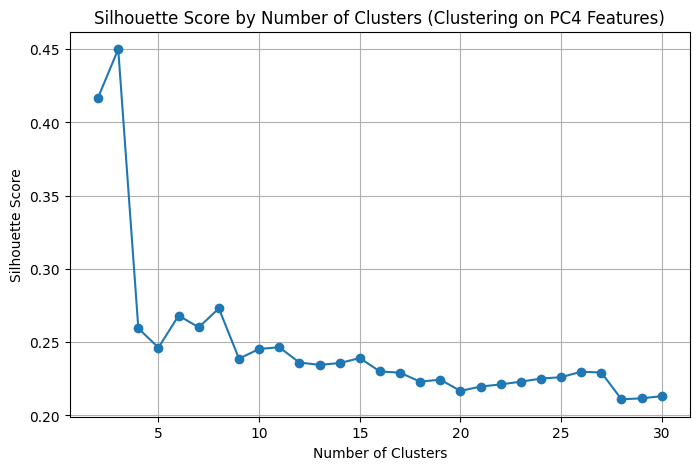

Number of observations in each cluster:
3    3492
1     369
2     126
Name: count, dtype: int64


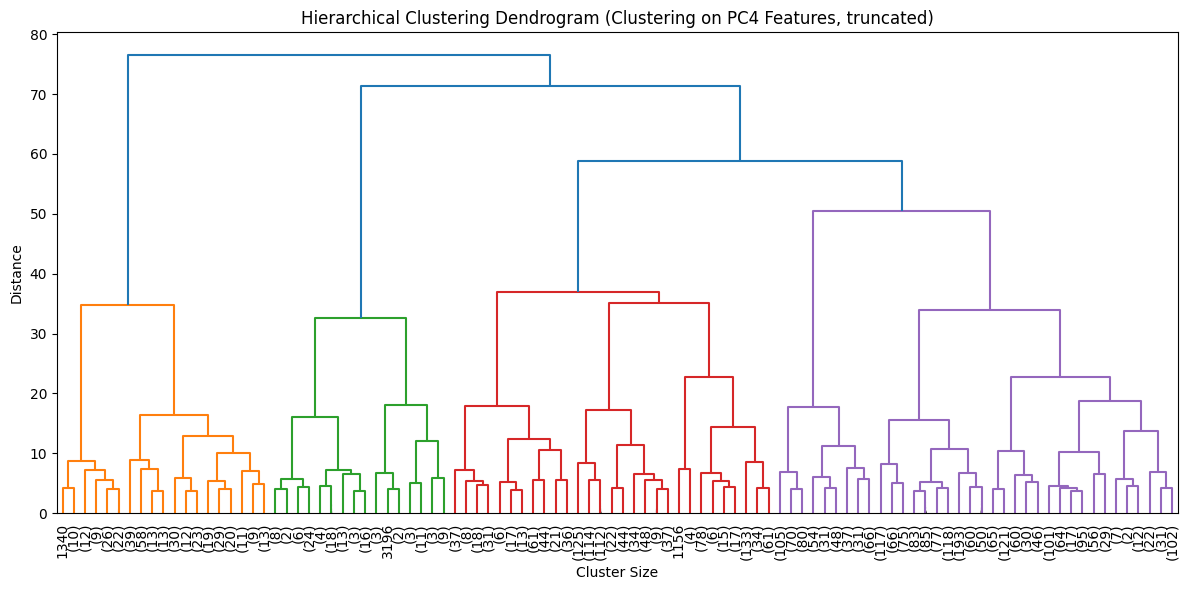

In [20]:
# --- STEP 1: Select PC4 PCA components for clustering ---
pc4_cols = [f'PC4_{i}' for i in range(1, 5)]
X_pc4 = fuel_energy_pca[pc4_cols].dropna()
clust_indices = X_pc4.index

# --- STEP 2: Standardize the PC4 data ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pc4)

# --- STEP 3: Hierarchical clustering (Ward linkage) ---
Z = linkage(X_scaled, method='ward')

# --- STEP 4: Find optimal number of clusters using silhouette score ---
range_n_clusters = range(2, 31)  # 2 to 30 clusters
sil_scores = []

for n_clusters in range_n_clusters:
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

optimal_n_clusters = range_n_clusters[np.argmax(sil_scores)]
print(f"Optimal number of clusters (highest silhouette score): {optimal_n_clusters}")

# --- Plot silhouette scores ---
plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.title('Silhouette Score by Number of Clusters (Clustering on PC4 Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# --- STEP 5: Assign optimal cluster labels ---
labels_optimal = fcluster(Z, optimal_n_clusters, criterion='maxclust')

# --- STEP 6: Append cluster labels back to original DataFrame (only for valid rows) ---
fuel_energy_pca_clusters = fuel_energy_pca.copy()
fuel_energy_pca_clusters['Cluster'] = np.nan  # initialize with NaN
fuel_energy_pca_clusters.loc[clust_indices, 'Cluster'] = labels_optimal

# --- Print cluster counts ---
print("Number of observations in each cluster:")
print(pd.Series(labels_optimal).value_counts())

# --- Optionally plot dendrogram (subset for readability) ---
plt.figure(figsize=(12, 6))
sample_size = min(100, len(X_scaled))  # Plot up to 100 samples for clarity
dendrogram(Z, truncate_mode='lastp', p=sample_size, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Clustering on PC4 Features, truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [21]:
fuel_energy_pca_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4703 entries, 0 to 4702
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   4703 non-null   object 
 1   account_id                     4703 non-null   int64  
 2   Year                           4703 non-null   int64  
 3   Countries                      4703 non-null   object 
 4   Primary_activity               4703 non-null   object 
 5   Primary_sector                 4703 non-null   object 
 6   Market_Cap_USD                 4038 non-null   float64
 7   Revenue_USD                    4060 non-null   float64
 8   ebitda_USD                     4060 non-null   float64
 9   grossProfit_USD                4060 non-null   float64
 10  netIncome_USD                  4060 non-null   float64
 11  cashAndCashEquivalents_USD     4060 non-null   float64
 12  shortTermInvestments_USD       4060 non-null   f

### HLM with PC4 Principal Components + Cluster Labels — Fuel & Energy Dataset

1. **Feature Assembly**
    - Use PC4 features and cluster labels (from hierarchical clustering) as predictors, with signed-log target and categoricals.
2. **Train/Test Split**
    - Split using years 2018–2022 (train) and 2023 (test), keeping only companies observed in both.
3. **Preprocessing**
    - Ensure cluster label is present and correct type.
    - Drop rows with missing values in model variables.
    - Restrict test set to only categories and clusters present in training.
4. **Modeling**
    - Fit a hierarchical mixed-effects model: PC4, cluster, year, country, and activity as fixed effects; company as a random effect.
5. **Evaluation & Output**
    - Predict on the test set, compute regression metrics, print model summary and feature importances, visualize predictions vs. observations.

---

**Result:**  
This pipeline extends HLM modeling to incorporate group structure found by clustering, enabling assessment of both multivariate PC4 and cluster effects in fuel & energy emissions.

                                        Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               slog_Scope_3_emissions_amount
No. Observations:                3242                  Method:                           ML                           
No. Groups:                      771                   Scale:                            0.9324                       
Min. group size:                 1                     Log-Likelihood:                   -5207.7346                   
Max. group size:                 5                     Converged:                        Yes                          
Mean group size:                 4.2                                                                                  
----------------------------------------------------------------------------------------------------------------------
                                                                           Coef.  Std.Err

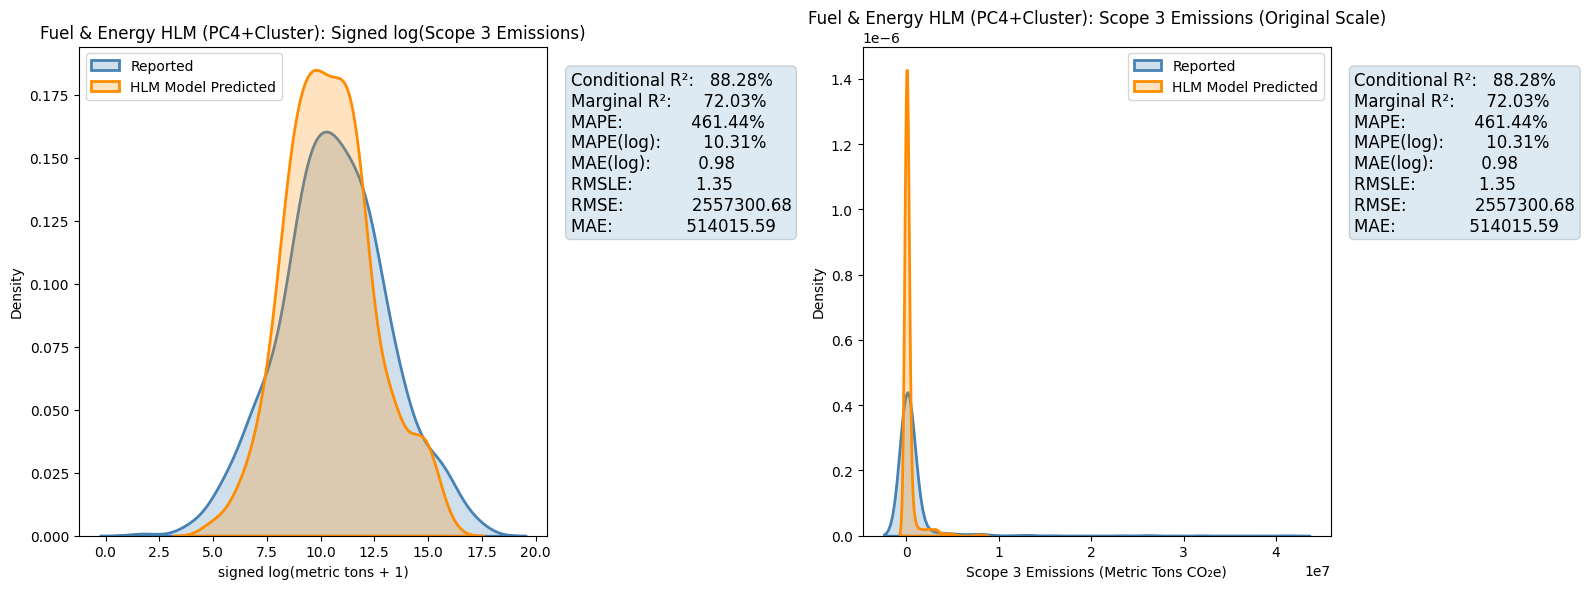

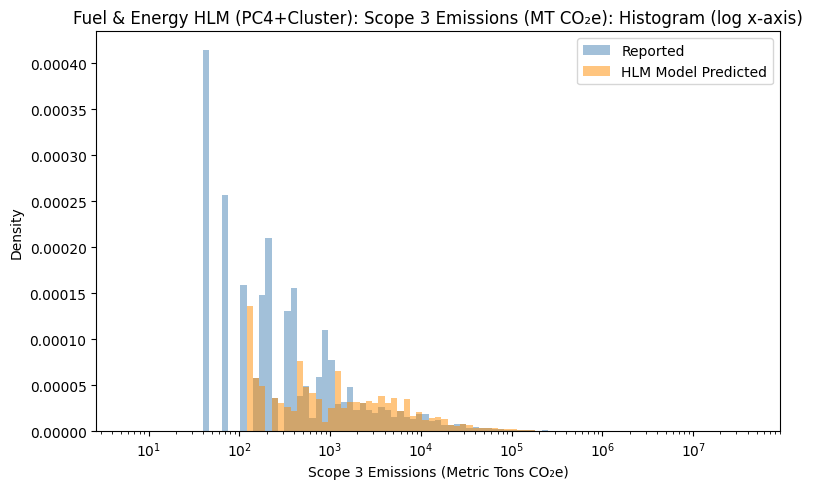

In [22]:
# --- PC4 + Cluster HLM ---

# Use fuel_energy_pca_clusters for all data splits and lookups
feature_cols_pc4_cluster = [f'PC4_{i}' for i in range(1, 5)] + ['Cluster']  # Use capital 'C' for cluster column
target_col = 'slog_Scope_3_emissions_amount'
cat_cols = ['Countries', 'Year', 'account_id', 'Primary_activity']

# If you want to include PC7 features in future modeling, they are available in this dataframe:
all_pc7_cols = [f'PC7_{i}' for i in range(1, 8)]

# All model variables for current run
all_model_vars = feature_cols_pc4_cluster + [target_col] + cat_cols

# --- Prepare Data ---
train_df_pc4 = fuel_energy_pca_clusters[
    (fuel_energy_pca_clusters['Year'] >= 2018) & (fuel_energy_pca_clusters['Year'] <= 2022)
].copy()
test_df_pc4 = fuel_energy_pca_clusters[
    (fuel_energy_pca_clusters['Year'] == 2023)
].copy()
valid_companies = set(train_df_pc4['account_id'].unique())
test_df_pc4 = test_df_pc4[test_df_pc4['account_id'].isin(valid_companies)].copy()

# --- 1. Ensure 'Cluster' column is present and correct dtype ---
if 'cluster' in train_df_pc4.columns and 'Cluster' not in train_df_pc4.columns:
    train_df_pc4['Cluster'] = train_df_pc4['cluster']
if 'cluster' in test_df_pc4.columns and 'Cluster' not in test_df_pc4.columns:
    test_df_pc4['Cluster'] = test_df_pc4['cluster']

# --- 2. Drop missing values in model variables ---
train_df_pc4c = train_df_pc4.dropna(subset=all_model_vars).copy()
test_df_pc4c  = test_df_pc4.dropna(subset=all_model_vars).copy()

# --- 2b. Set Cluster to int/categorical as appropriate ---
train_df_pc4c['Cluster'] = train_df_pc4c['Cluster'].astype(int)
test_df_pc4c['Cluster'] = test_df_pc4c['Cluster'].astype(int)

# --- 3. Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity', 'Cluster']:
    train_cats = set(train_df_pc4c[cat_col].unique())
    n_before = len(test_df_pc4c)
    test_df_pc4c = test_df_pc4c[test_df_pc4c[cat_col].isin(train_cats)]
    n_after = len(test_df_pc4c)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_pc4c.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- 4. Model formula ---
    fixed_effects = (
        ' + '.join([col if col != 'Cluster' else 'C(Cluster)' for col in feature_cols_pc4_cluster]) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col} ~ {fixed_effects}'

    # --- 5. Fit the mixed-effects model ---
    import statsmodels.formula.api as smf
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_pc4c, groups=train_df_pc4c['account_id'])
        mdf_pc4c = md.fit(reml=False)
    print(mdf_pc4c.summary())

    # --- 6. CALCULATE CONDITIONAL AND MARGINAL R² ---
    import numpy as np
    var_fixed = np.var(mdf_pc4c.fittedvalues)
    var_resid = mdf_pc4c.scale
    var_random = mdf_pc4c.cov_re.iloc[0, 0] if mdf_pc4c.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- 7. Predict on test set ---
    test_df_pc4c['predicted_log'] = mdf_pc4c.predict(test_df_pc4c)
    test_df_pc4c['predicted'] = np.sign(test_df_pc4c['predicted_log']) * (np.expm1(np.abs(test_df_pc4c['predicted_log'])))

    # --- 8. Metrics ---
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
    y_true_log = test_df_pc4c[target_col]
    y_pred_log = test_df_pc4c['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_pc4c['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nFuel & Energy HLM with PC4+Cluster Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- 9. Feature coefficients ---
    import pandas as pd
    coef_df = pd.DataFrame({
        'coef': mdf_pc4c.params,
        'pvalue': mdf_pc4c.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- 10. Visualization ---
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Fuel & Energy HLM (PC4+Cluster): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Fuel & Energy HLM (PC4+Cluster): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Fuel & Energy HLM (PC4+Cluster): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 11. RETURN METRICS FOR SUMMARY TABLE ---
    pc4_cluster_model_metrics = {
        "Model": "HLM PC4+Cluster",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_pc4c),
        "# Obs (test)": len(test_df_pc4c),
        "# Obs (train/test)": f"{len(train_df_pc4c)}/{len(test_df_pc4c)}"
    }

### Model Metrics Summary: Fuel & Energy HLM Comparison

In [27]:
# Collect metrics dicts from each model; change names as needed
metrics_dicts = [
    PC7_model_metrics,        # e.g., "HLM PC7"
    PC4_model_metrics,        # e.g., "HLM PC4"
    pc4_cluster_model_metrics # e.g., "HLM PC4 + Cluster"
]

# Attach observation counts, convergence info, and explained variance to each dictionary
for metrics, train, test, model, explained_var in zip(
        metrics_dicts,
        [train_df_PC7, train_df_PC4, train_df_pc4c],
        [test_df_PC7, test_df_PC4, test_df_pc4c],
        [mdf_PC7, mdf_PC4, mdf_pc4c],
        [
            sum(pca7.explained_variance_ratio_),     # PC7 explained variance
            sum(pca4.explained_variance_ratio_),     # PC4 explained variance
            sum(pca4.explained_variance_ratio_)      # PC4 (cluster uses same PC4)
        ]):
    metrics["# Obs (train)"] = len(train)
    metrics["# Obs (test)"] = len(test)
    metrics["# Obs (train/test)"] = f"{len(train)}/{len(test)}"
    metrics["Converged"] = bool(getattr(model, "converged", False))
    metrics["PC Explained Variance"] = explained_var

# Add a new row for your "Optimized" model
optimized_row = {
    "Model": "Optimized Fuel Energy HLM",
    "Conditional_R2": 0.8762,   # as a fraction, not percent
    "Marginal_R2": 0.7612,
    "RMSE": 2545061.38,
    "MAE": 477732.56,
    "MAE_log": 0.8,
    "RMSLE": 1.11,
    "MAPE": 164.79,
    "# Obs (train/test)": "3242/679",
    "Converged": True,  # or True/False if known
    "PC Explained Variance": np.nan
}
metrics_dicts.append(optimized_row)

metrics_df = pd.DataFrame(metrics_dicts)

# Order columns for summary, with variance before Converged
desired_order = [
    "Model", "PC Explained Variance", "Conditional_R2", "Marginal_R2", "RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "# Obs (train/test)", "Converged"
]

# Add MAE_log if missing
if "MAE_log" not in metrics_df.columns:
    metrics_df["MAE_log"] = np.nan

metrics_df = metrics_df[[col for col in desired_order if col in metrics_df.columns]]

# Format for display
metrics_df_display = metrics_df.copy()
if "Conditional_R2" in metrics_df_display.columns:
    metrics_df_display["Conditional_R2"] = (metrics_df_display["Conditional_R2"].astype(float) * 100).map("{:.2f}%".format)
if "Marginal_R2" in metrics_df_display.columns:
    metrics_df_display["Marginal_R2"] = (metrics_df_display["Marginal_R2"].astype(float) * 100).map("{:.2f}%".format)
for col in ["RMSE", "MAE", "MAE_log", "RMSLE", "MAPE"]:
    if col in metrics_df_display.columns:
        metrics_df_display[col] = metrics_df_display[col].astype(float).map("{:.2f}".format)
if "PC Explained Variance" in metrics_df_display.columns:
    metrics_df_display["PC Explained Variance"] = metrics_df_display["PC Explained Variance"].apply(
        lambda v: "{:.2%}".format(v) if pd.notnull(v) else ""
    )
if "Converged" in metrics_df_display.columns:
    metrics_df_display["Converged"] = metrics_df_display["Converged"].map({True: "Yes", False: "No", np.nan: ""})

# Display in notebook or print
try:
    display(metrics_df_display)
except Exception:
    print(metrics_df_display.to_string(index=False))

,Model,PC Explained Variance,Conditional_R2,Marginal_R2,RMSE,MAE,MAE_log,RMSLE,MAPE,# Obs (train/test),Converged
0,HLM PC7,81.88%,87.81%,74.46%,2571516.39,508208.51,0.90,1.24,334.41,3242/709,Yes
1,HLM PC4,62.43%,88.31%,71.93%,2561281.50,515717.13,0.98,1.35,473.77,3242/709,Yes
2,HLM PC4+Cluster,62.43%,88.28%,72.03%,2557300.68,514015.59,0.98,1.35,461.44,3242/709,Yes
3,Optimized Fuel Energy HLM,,87.62%,76.12%,2545061.38,477732.56,0.80,1.11,164.79,3242/679,Yes
